# 2D Batch Generator

In [1]:
import numpy as np
import pandas as pd
import keras

Using TensorFlow backend.


In [2]:
keras.__version__

'2.2.0'

In [3]:
import tensorflow

In [5]:
tensorflow.__version__

'1.8.0'

## Metadata vs Lane
    * Metadata is the full dataset annotations
    * Lane is referres to the 'clean' version
    
    Note: The filenames column have the whole path to the image :)
    
    The data is sampled at 20Hz


In [3]:
# Open all 
lane1 = pd.read_csv('Dataset/2016-01-30--11-24-51/Metadata/lane_df.csv',index_col=0)

#lane2 = pd.read_csv('Dataset/2016-01-30--13-46-00/Metadata/lane_df.csv',index_col=0)

#lane3 = pd.read_csv('Dataset/2016-01-31--19-19-25/Metadata/lane_df.csv',index_col=0)

lane4 = pd.read_csv('Dataset/2016-02-02--10-16-58/Metadata/lane_df.csv',index_col=0)

lane5 = pd.read_csv('Dataset/2016-02-08--14-56-28/Metadata/lane_df.csv',index_col=0)

lane6 = pd.read_csv('Dataset/2016-02-11--21-32-47/Metadata/lane_df.csv',index_col=0)

lane7 = pd.read_csv('Dataset/2016-03-29--10-50-20/Metadata/metadata.csv',index_col=0)

#lane8 = pd.read_csv('Dataset/2016-03-29--10-50-20/Metadata/metadata.csv',index_col=0)

#lane9 = pd.read_csv('Dataset/2016-04-21--14-48-08/Metadata/metadata.csv',index_col=0)

#lane10 = pd.read_csv('Dataset/2016-05-12--22-20-00/Metadata/metadata.csv',index_col=0)

#lane11 = pd.read_csv('Dataset/2016-06-02--21-39-29/Metadata/metadata.csv',index_col=0)

#test = pd.read_csv('Dataset/2016-06-08--11-46-01/Metadata/metadata.csv',index_col=0)



In [4]:
X = []
Y = []
for df in [lane1, lane5, lane6, lane7]:#, lane8, lane9, lane10]:
    X.append(df['filenames'].values)
    Y.append(df['steering_angle'].values)

X = np.concatenate(X)
Y = np.concatenate(Y).astype('float32')

# Subsample at 10 Hz
X = X[::2]
Y = Y[::2]

print('Shape X', np.shape(X))
print('Shape Y', np.shape(Y))

Shape X (93054,)
Shape Y (93054,)


## Opening images using the lane reference

Using TensorFlow backend.


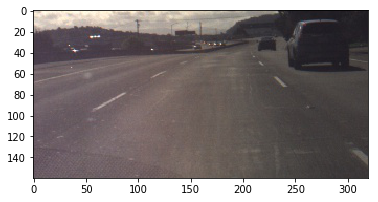

In [5]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

filename = lane1['filenames'].iloc[0]
img = np.array(image.load_img(filename))
plt.imshow(img)

In [6]:
from keras.utils import Sequence
class Batch_generator(Sequence):
    '''Generates batches of images and labels on the fly from disc. 
    Uses process_line() function to perform image reading transformation.
    x_set: Numpy array with filenames (strings)
    y_set: Numpy array with binary gender labels (0,1)
    batch_size: Number of samples per batch
    '''
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size


    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
            self.batch_size]

        return np.array([process_line(file_name)
                   for file_name in batch_x]), batch_y.astype('float32')

    
def process_line(filename):
    '''Process one line of the batch directory.------------------------
     # Open image from lfw/ folder. Convert it to Numpy array    
    '''
    return  np.array(image.load_img(filename)).astype('float32')



In [25]:
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input, Lambda, Conv2D
#from keras_vggface.vggface import VGGFace
#from keras_vggface import utils
from keras.preprocessing import image
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json, Sequential
from keras.utils import Sequence
from keras.layers import Flatten, BatchNormalization, Activation, MaxPool2D, Dropout
import math
import keras


def baseline(input_shape=(160,320,3), dropout=0.1):
    """
   Classic NVIDIA model.
    """
    model = Sequential()
    
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=input_shape))
    model.add(Conv2D(24, (5, 5), activation='elu', strides=(2, 2), input_shape=input_shape))
    #model.add(BatchNormalization())

    model.add(Conv2D(36, (5, 5), activation='elu', strides=(2, 2)))
    #model.add(BatchNormalization())

    model.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2)))
    #model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3, 3), activation='elu'))
    #model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), activation='elu'))
    #model.add(BatchNormalization())
    
    model.add(Dropout(dropout))
    model.add(Flatten())
    
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    
    adam = Adam(lr=1e-4)
    model.compile(optimizer=adam, loss=rmse)
    
    #model.summary()

    return model



In [8]:
from keras.layers import ELU

import keras as K

def rmse(y_true, y_pred):
        return K.backend.sqrt(K.backend.mean(K.backend.square(y_pred - y_true), axis=-1)) 

    

def commaai_model():

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(160, 320, 3), output_shape=(
    160, 320, 3)))
    model.add(Conv2D(16, (8, 8), strides=4, padding="same"))
    model.add(ELU())
    model.add(Conv2D(32, (5, 5), strides=2, padding="same"))
    model.add(ELU())
    model.add(Conv2D(64, (5, 5), strides=2, padding="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))

    adam = Adam(lr=1e-4)
    model.compile(optimizer=adam, loss=rmse)
    # print('steering model is created and compiled...')
    return model

In [9]:
# Normalize target
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

scaler.fit(Y.reshape(-1,1))

y = scaler.transform(Y.reshape(-1,1))


In [10]:
import random
proportion = 1
# Generate a random selection of indexes
indexes = random.sample(range(0, X.shape[0]), int(X.shape[0]*proportion))

# Select desired examples
shuffle_X = X[indexes]
shuffle_Y = y[indexes].astype('float32')


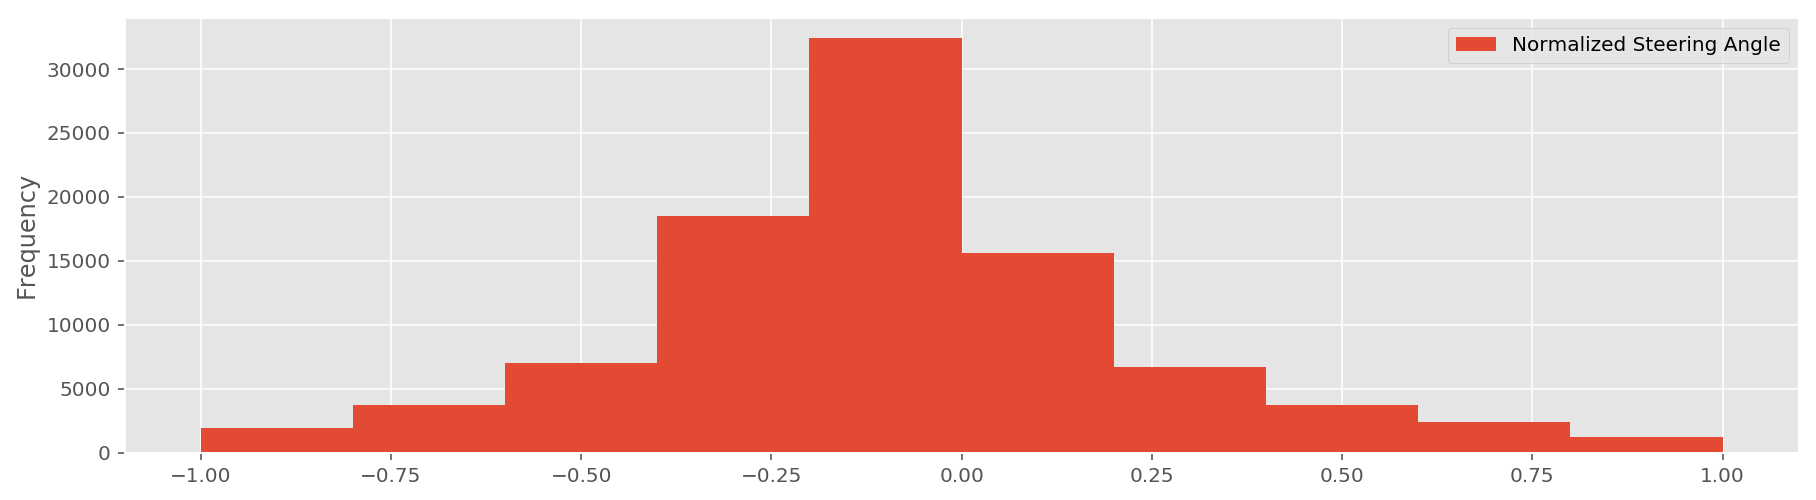

In [24]:
df_y = pd.DataFrame(shuffle_Y)
df_y.columns = ['Normalized Steering Angle']
df_y.plot.hist()

In [193]:
!pip install pydot

    100% |████████████████████████████████| 133kB 3.9MB/s ta 0:00:01
  Running setup.py bdist_wheel for pydot ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/6a/a5/14/25541ebcdeaf97a37b6d05c7ff15f5bd20f5e91b99d313e5b4
Successfully built pydot
distributed 1.21.8 requires msgpack, which is not installed.


In [26]:
from keras.utils import plot_model
model = baseline()

plot_model(model, to_file='nvidia_no_BN.png', show_shapes=True)

In [27]:

# Create batch generator for training and validation
#img_path = './CACD_NUMPY/'
batch_size = 100

train_X = shuffle_X[:75000]
train_Y = shuffle_Y[:75000]

val_X = shuffle_X[75000:89000]
val_Y = shuffle_Y[75000:89000]

test_X = shuffle_X[89000:]
test_Y = shuffle_Y[89000:]

# Initialize batch generators
train_gen = Batch_generator(train_X, train_Y, batch_size)
val_gen = Batch_generator(val_X, val_Y, batch_size)


steps_per_epoch = int(train_X.shape[0] / batch_size)
validation_steps = int(val_X.shape[0] / batch_size)

# Create model
#model = baseline()
#model = commaai_model()
# For a binary classification problem
#model.compile(optimizer='SGD',
#              loss='mse')


# Configure Keras Callbacks
model_name = 'checkpoint_nvidia_model_noBN.hdf5'
min_delta=.0005
patience = 5

#checkpoint to save model after each epoch
snapshot = keras.callbacks.ModelCheckpoint(model_name, 
                                            monitor='val_loss', 
                                            verbose=1, 
                                            save_best_only=True, 
                                            mode='min')

# Learning rate scheduler
reduce_LR  = ReduceLROnPlateau(monitor='val_loss',factor=0.5,
                               patience=3,verbose=True)

#stop training if the validation error stops improving.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           min_delta=min_delta, 
                                           patience=patience, 
                                           verbose=1, 
                                           mode='auto')

# Training step
history = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch,
                    epochs=100, verbose=1,
                    callbacks=[early_stop, reduce_LR, snapshot], validation_data=val_gen,
                    validation_steps= validation_steps, class_weight=None,
                    max_queue_size=10, workers=8,
                    use_multiprocessing=True, shuffle=True, initial_epoch=0)

model.save('last_nvidia_model_noBN.hdf5')


Epoch 1/100
750/750 [==============================] - 207s 276ms/step - loss: 0.2125 - val_loss: 0.1864

Epoch 00001: val_loss improved from inf to 0.18640, saving model to checkpoint_nvidia_model_noBN.hdf5
Epoch 2/100
750/750 [==============================] - 205s 273ms/step - loss: 0.1723 - val_loss: 0.1617

Epoch 00002: val_loss improved from 0.18640 to 0.16166, saving model to checkpoint_nvidia_model_noBN.hdf5
Epoch 3/100
750/750 [==============================] - 204s 272ms/step - loss: 0.1485 - val_loss: 0.1478

Epoch 00003: val_loss improved from 0.16166 to 0.14783, saving model to checkpoint_nvidia_model_noBN.hdf5
Epoch 4/100
750/750 [==============================] - 203s 271ms/step - loss: 0.1320 - val_loss: 0.1336

Epoch 00004: val_loss improved from 0.14783 to 0.13364, saving model to checkpoint_nvidia_model_noBN.hdf5
Epoch 5/100
750/750 [==============================] - 202s 269ms/step - loss: 0.1188 - val_loss: 0.1279

Epoch 00005: val_loss improved from 0.13364 to 0.1

In [30]:
from keras.models import load_model

In [36]:
net = load_model('_nvidia_model.hdf5',custom_objects={'rmse': rmse})

OSError: Unable to open file (unable to open file: name = 'last_nvidia_model.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [32]:
from tqdm import tqdm
test = []
for i in tqdm(range(test_X.shape[0])):
    test.append(net.predict(np.expand_dims(process_line(test_X[i]), axis=0)))

100%|██████████| 4054/4054 [00:18<00:00, 219.40it/s]


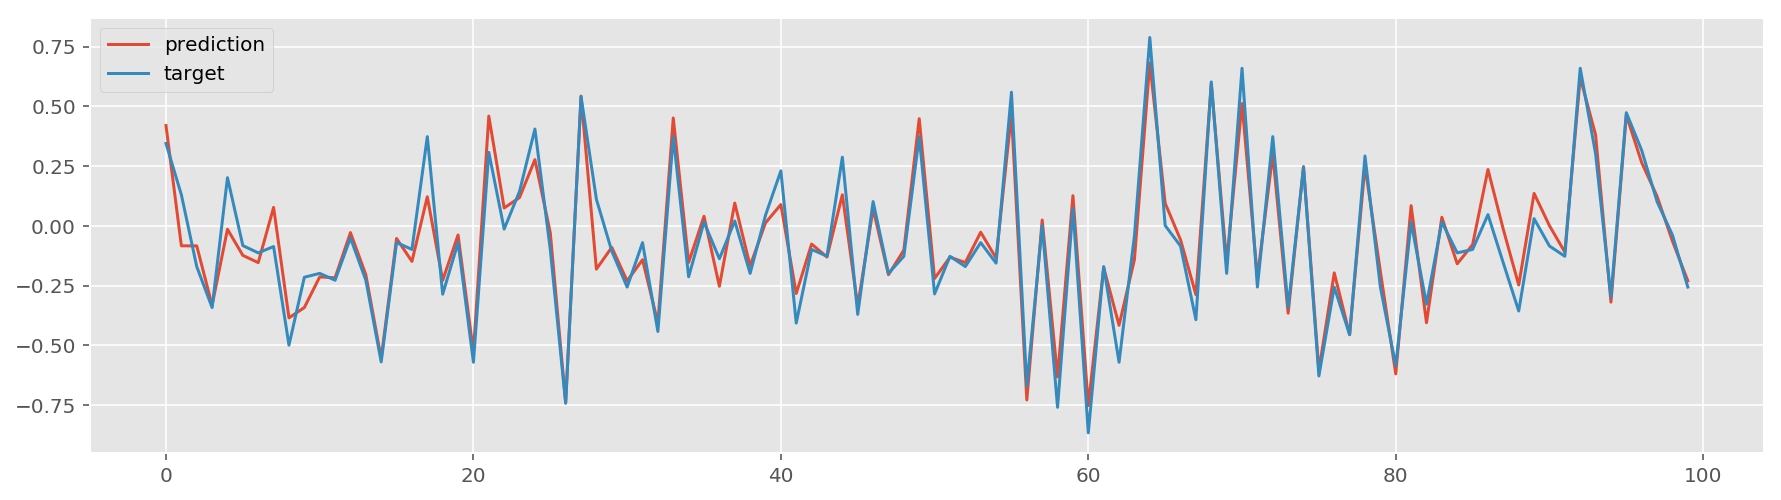

In [33]:
plt.plot(np.array(test).reshape(-1)[100:200], label='prediction')
plt.plot(test_Y[100:200], label='target')
plt.legend()

In [34]:
import math
def error(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred - y_true), axis=-1)) 
np.mean(error(test_Y,test))

0.33628088

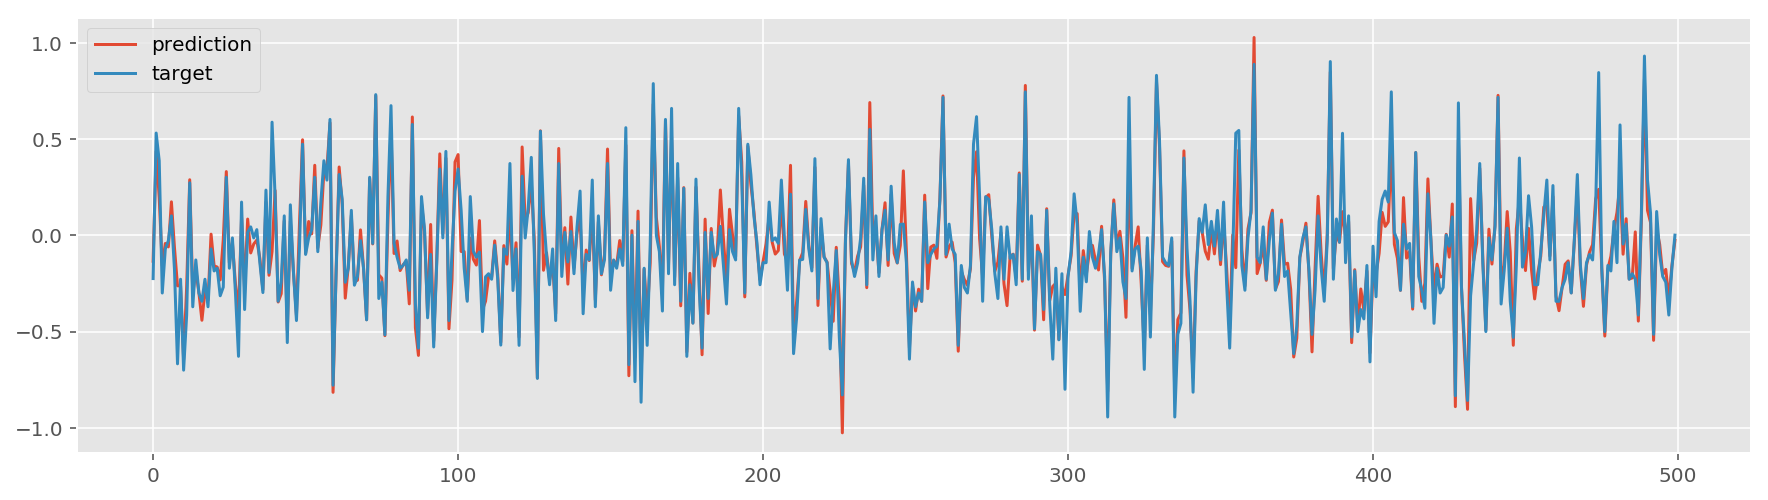

In [35]:
plt.plot(np.array(test).reshape(-1)[:500], label='prediction')
plt.plot(test_Y[:500], label='target')
plt.legend()

In [156]:
np.mean(error(test_Y,test))

0.2805248

5

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = 15, 4
plt.style.use('ggplot')

def plot_train_loss(history):
  
  #plt.plot(history.history['acc'])
  #plt.plot(history.history['val_acc'])
  #plt.title('model accuracy')
  #plt.ylabel('accuracy')
  #plt.xlabel('epoch')
  #plt.legend(['train', 'test'], loc='upper left')
  #plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

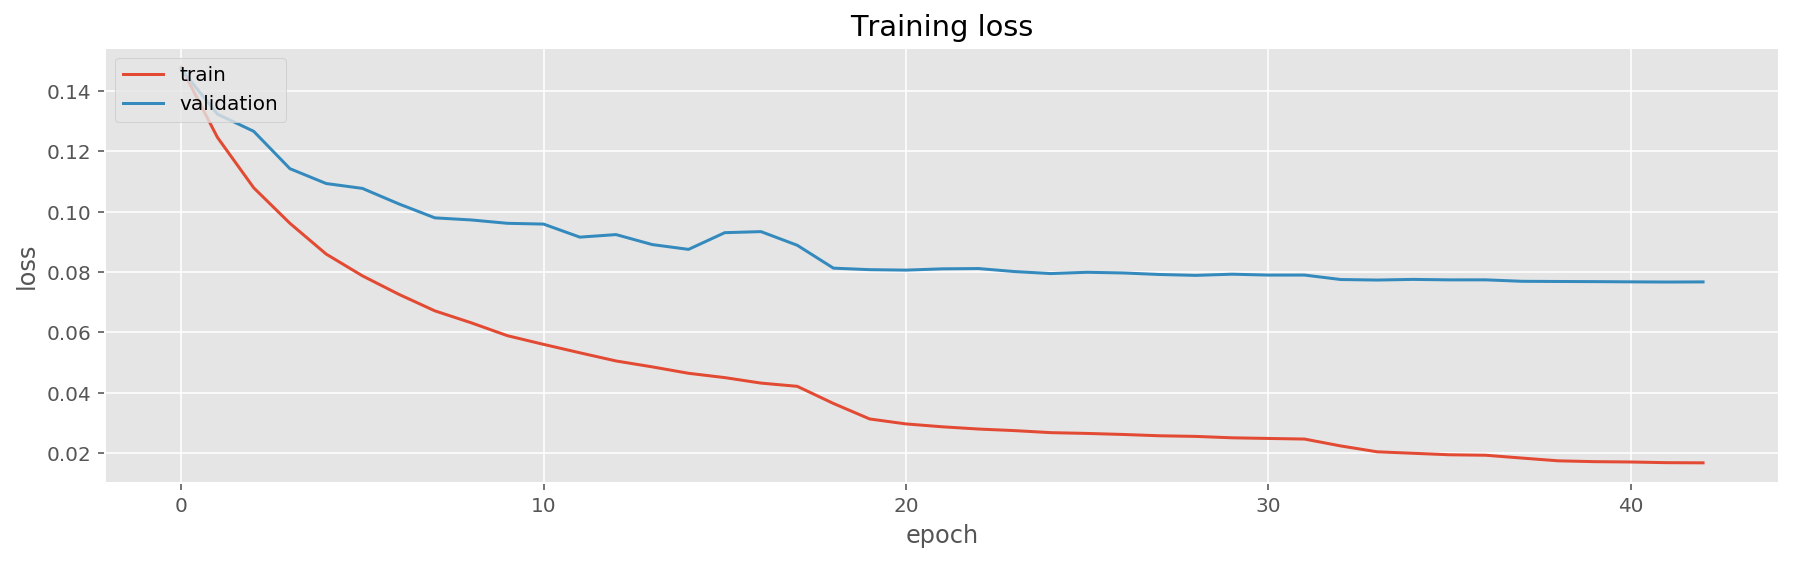

In [36]:
plot_train_loss(history)

In [28]:

def plot_train_loss(history):
  
  #plt.plot(history.history['acc'])
  #plt.plot(history.history['val_acc'])
  #plt.title('model accuracy')
  #plt.ylabel('accuracy')
  #plt.xlabel('epoch')
  #plt.legend(['train', 'test'], loc='upper left')
  #plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

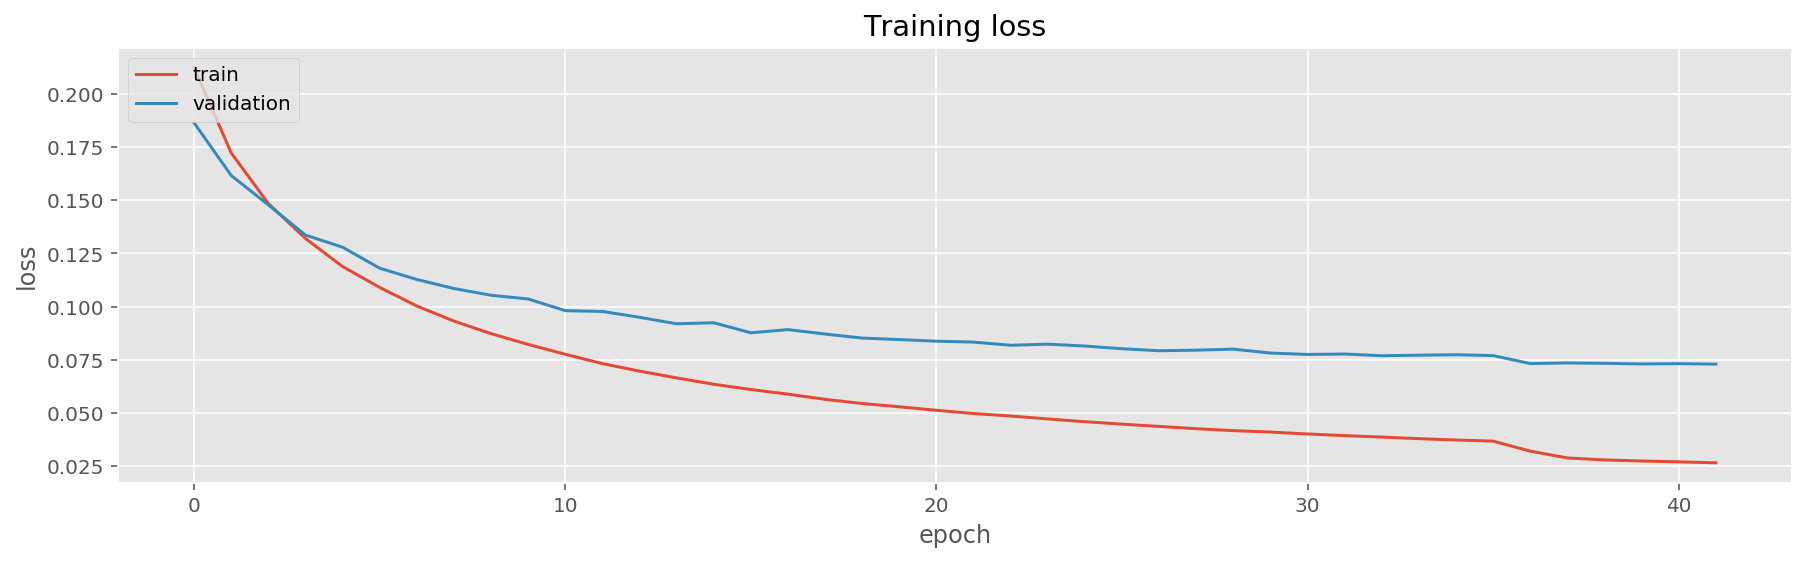

In [29]:
plot_train_loss(history)